In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from mpl_toolkits.axes_grid1 import make_axes_locatable
config = {'font.family': 'Times New Roman',
          'font.size': 13,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'mathtext.fontset': 'stix',
          'savefig.dpi': 300
         }
plt.rcParams.update(config)

# 导入 KLE 函数
from utils.KLE import eigen_value_solution
from utils.KLE import sort_lamda
from utils.KLE import eigen_func

nx = 64
ny = 64

L_x = nx * 200 # 区域长度
L_y = ny * 200
domain = L_x * L_y

eta = 0.1 * L_x # 相关长度, 相关长度是指某个点影响的范围, 越小越复杂

dx, dy = L_x / nx, L_y / ny

x = np.arange(dx, L_x + dx, dx)
y = np.arange(dy, L_y + dy, dy)

weight = 0.40 # 保留 70% 的信息

mean_logk = 0
var = 1.0

# ! 计算所需特征值个数
n_test = 50
lamda_x, w_x0, cumulate_lamda_x = eigen_value_solution(eta, L_x, var, n_test)
lamda_y, w_y0, cumulate_lamda_y = eigen_value_solution(eta, L_y, var, n_test)
# ! 二维特征值计算, 混合, 排序, 截断
lamda_xy, w_x, w_y, n, cum_lamda = sort_lamda(lamda_x, w_x0, lamda_y, w_y0, domain, var, weight)

n_eigen = n
print("保留随机数的数量: ", n_eigen)

# ! 根据 weight 获取所需计算特征值个数, 并计算特征值以及特征函数值
fn_x, fn_y = [], []
for i_x in range(nx):
    f_x = eigen_func(n_eigen, w_x, eta, L_x, x[i_x])
    fn_x.append([f_x, x[i_x]])
    
for i_y in range(ny):
    f_y = eigen_func(n_eigen, w_y, eta, L_y, y[i_y])
    fn_y.append([f_y, y[i_y]])
    
print('特征函数计算完成')

def calculate_logk(nx, ny, mean_logk, lamda_xy, fn_x, fn_y, kesi):
    kesi = kesi.reshape(1, -1) # ! 增维, 必须
    logk = np.zeros((nx, ny))
    for i_x in range(nx):
        for i_y in range(ny):
            logk[i_y, i_x] = mean_logk + np.sum(np.sqrt(lamda_xy) * fn_x[i_x][0] * \
                                    fn_y[i_y][0] * kesi.transpose())
    return logk

# ! 随机数组及渗透系数场实现
seed_n = 66
np.random.seed(seed_n)
n_logk = 50 # 渗透率场实现个数

kesi = np.zeros((n_logk, n_eigen)) # 随机数数组
logk = np.zeros((n_logk, nx, ny)) # 渗透率场数组

for i_logk in range(n_logk):
    kesi[i_logk, :] = np.random.randn(n_eigen) # 随机数数组
    logk[i_logk, :, :] = calculate_logk(nx, ny, mean_logk, lamda_xy, fn_x, fn_y, kesi[i_logk])
    
    # 由随机数计算渗透率场
    # for i_x in range(nx):
    #     for i_y in range(ny):
    #         logk[i_logk,i_y,i_x] = mean_logk + np.sum(np.sqrt(lamda_xy) * fn_x[i_x][0] * \
    #                                fn_y[i_y][0] * kesi[i_logk:i_logk + 1].transpose())

保留随机数的数量:  25
特征函数计算完成


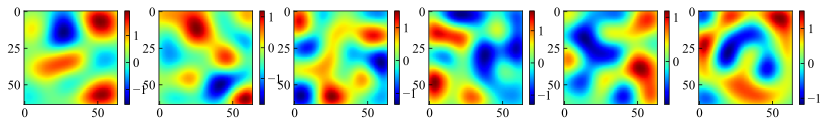

In [18]:
fig, axes = plt.subplots(1, 6, figsize=(14, 8))
ax = axes.flatten() # 子图展平,将 ax 由 n*m 的 Axes 组展平成 1*nm 的Axes组 (二维变一维)
for i in range(6):
    im = ax[i].imshow(logk[i], cmap='jet', interpolation='nearest', aspect='equal') # origin='lower', 
    
    # 创建 colorbar 的区域
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    # 在子图上增加 colorbar
    fig.colorbar(im, cax=cax)

plt.subplots_adjust(top=None, bottom=None, left=None, right=None, hspace=None, wspace=0.28)      
plt.show()

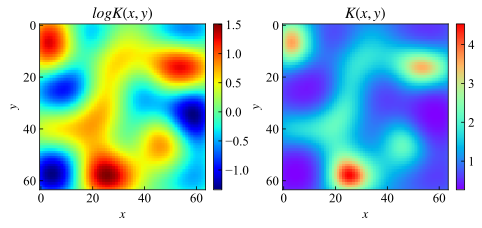

In [19]:
# ! 从上述 logk 中挑选一个
simple_logk = calculate_logk(nx, ny, mean_logk, lamda_xy, fn_x, fn_y, kesi[2].reshape(1, -1))

k = np.exp(simple_logk) # ! 渗透率场对数转化

plt.figure(figsize = (8, 3))
plt.subplot(121)
mm = plt.imshow(simple_logk, cmap='jet', interpolation='nearest', aspect='equal') # origin='lower', 
                # extent=[0, 10, 0,10])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("$logK(x,y)$")
plt.colorbar(mm, fraction=0.046, pad=0.04)

plt.subplot(122)
mm = plt.imshow(k, cmap='rainbow', interpolation='nearest', aspect='equal') # origin='lower', 

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("$K(x,y)$")
plt.colorbar(mm, fraction=0.046, pad=0.04)
# ! 保存
# np.save('KLE48.npy', np.array([nx, ny, mean_logk, lamda_xy, fn_x, fn_y, kesi[2].reshape(1, -1)], dtype=object))
plt.show()

In [9]:
# # ! 外部读取
# nx, ny, mean_logk, lamda_xy, fn_x, fn_y, kesi = np.load('data48.npy', allow_pickle=True)

# def calculate_logk(nx, ny, mean_logk, lamda_xy, fn_x, fn_y, kesi):
#     kesi = kesi.reshape(1, -1) # 增维, 必须
#     logk = np.zeros((nx, ny))
#     # 由随机数计算渗透率场
#     for i_x in range(nx):
#         for i_y in range(ny):
#             logk[i_y, i_x] = mean_logk + np.sum(np.sqrt(lamda_xy) * fn_x[i_x][0] * \
#                                     fn_y[i_y][0] * kesi.transpose())
#     return logk

# kk = calculate_logk(nx, ny, mean_logk, lamda_xy, fn_x, fn_y, kesi)
# plt.imshow(kk, cmap='jet', interpolation='nearest', aspect='equal')

In [11]:
# # plt.subplots() 是一个函数，返回一个包含 figure 和 axes 数组对象的元组
# figure, axes = plt.subplots(5, 4, figsize=(12, 8), dpi=150)
# ax = axes.flatten() #子图展平, 将ax由n*m的Axes组展平成1*nm的Axes组(二维变一维)
# for i in range(20):
#     sns.kdeplot(data=logk[i].flatten(), ax=ax[i])
#     sns.kdeplot(data=(logk[i+10]+np.log(3)).flatten(), ax=ax[i])
#     #ax[i].axline([logk[i].mean(),0],[logk[i].mean(),1],c='r')
#     ax[i].axline([0, 0], [0, 1], c='r')
#     ax[i].axline([np.log(3), 0], [np.log(3), 1], c='r')

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# figure ,axes =plt.subplots(5,4,figsize=(12,8),dpi=150)
# # 设置显示中文
# # plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
# # plt.rcParams['axes.unicode_minus']=False     # 正常显示负号
# ax = axes.flatten() #子图展平,将ax由n*m的Axes组展平成1*nm的Axes组(二维变一维)
# for i in range(20):
#     im=ax[i].imshow((1-mpsdata[i])*np.exp(logk[i])+mpsdata[i]*np.exp(logk[i+80]+np.log(3)),origin='lower',interpolation='nearest',aspect='equal',cmap='jet')
# #     plt.xlabel('$x$')
# #     plt.ylabel('$y$')
#     # 创建 colorbar 的区域
#     divider = make_axes_locatable(ax[i])
#     cax = divider.append_axes("right", size="5%", pad=0.1)
#     # 在子图上增加 colorbar
#     figure.colorbar(im, cax=cax)

# mpsdata = np.load("H:/deep_learning/numpy_data/mpsdata.npy")
# logk = np.load("H:/deep_learning/numpy_data/logk.npy")

# zuhe=(1-mpsdata)*np.exp(logk[:3000])+mpsdata*np.exp(logk[3000:]+np.log(2))

# mm=plt.imshow(zuhe[2],origin='lower',cmap='jet',interpolation='nearest',aspect='equal',)
#            # extent=[0, 1, 0,1])
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.title("$K(x,y)$")
# # plt.xlim(0,10)
# # plt.ylim(0,10)
# plt.colorbar(mm,fraction=0.046, pad=0.04)